In [1]:
from utils import get_full_data
from utils import get_full_test_data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train, y_train, X_test, y_test = get_full_data()
X_train.describe()

loaded df from C:\Users\jonas\Desktop\Tu-Wien\Semester_1\NLP\git_classroom\data/dreaddit-train.csv with 115 columns.
number of na values in the whole df: 0
loaded df from C:\Users\jonas\Desktop\Tu-Wien\Semester_1\NLP\git_classroom\data/dreaddit-test.csv with 115 columns.
number of na values in the whole df: 0


label   confidence  social_timestamp  social_karma   syntax_ari  \
count  2833.000000  2833.000000      2.833000e+03   2833.000000  2833.000000   
mean      0.524532     0.809078      1.518108e+09     18.272856     4.684404   
std       0.499486     0.177045      1.551924e+07     79.488322     3.308072   
min       0.000000     0.428571      1.483274e+09      0.000000    -5.685000   
25%       0.000000     0.600000      1.509681e+09      2.000000     2.466800   
50%       1.000000     0.800000      1.517063e+09      5.000000     4.320896   
75%       1.000000     1.000000      1.530898e+09     10.000000     6.500878   
max       1.000000     1.000000      1.542592e+09   1435.000000    24.074231   

       lex_liwc_WC  lex_liwc_Analytic  lex_liwc_Clout  lex_liwc_Authentic  \
count  2833.000000        2833.000000     2833.000000         2833.000000   
mean     86.070597          35.237490       40.897289           67.108814   
std      32.280363          26.488452       31.554140           32.834488   
min       8.000000           1.000000        1.000000            1.000000   
25%      65.000000          12.410000       12.130000           41.420000   
50%      81.000000          29.420000       33.520000           80.820000   
75%     101.000000          55.090000       69.290000           96.180000   
max     310.000000          99.000000       99.000000           99.000000   

       lex_liwc_Tone  ...  lex_dal_min_pleasantness  lex_dal_min_activation  \
count    2833.000000  ...               2833.000000             2833.000000   
mean       33.381613  ...                  1.087687                1.119745   
std        35.290945  ...                  0.116177                0.084606   
min         1.000000  ...                  1.000000                1.000000   
25%         1.420000  ...                  1.000000                1.000000   
50%        25.770000  ...                  1.000000                1.142900   
75%        61.550000  ...                  1.142900                1.142900   
max        99.000000  ...                  1.666700                1.500000   

       lex_dal_min_imagery  lex_dal_avg_activation  lex_dal_avg_imagery  \
count          2833.000000             2833.000000          2833.000000   
mean              1.000141                1.722706             1.536181   
std               0.005313                0.047803             0.102769   
min               1.000000                1.485400             1.200000   
25%               1.000000                1.691420             1.469700   
50%               1.000000                1.721390             1.530000   
75%               1.000000                1.751690             1.595960   
max               1.200000                2.007400             2.066670   

       lex_dal_avg_pleasantness  social_upvote_ratio  social_num_comments  \
count               2833.000000          2833.000000          2833.000000   
mean                   1.879282             0.843357             9.951994   
std                    0.058728             0.174890            21.816886   
min                    1.561150             0.140000             0.000000   
25%                    1.841780             0.750000             2.000000   
50%                    1.878240             0.890000             5.000000   
75%                    1.916220             1.000000            10.000000   
max                    2.158490             1.000000           416.000000   

       syntax_fk_grade    sentiment  
count      2833.000000  2833.000000  
mean          5.451007     0.040778  
std           2.533213     0.195363  
min          -1.918000    -1.000000  
25%           3.730811    -0.072222  
50%           5.210000     0.045000  
75%           6.855952     0.166667  
max          21.198919     1.000000  

[8 rows x 111 columns]

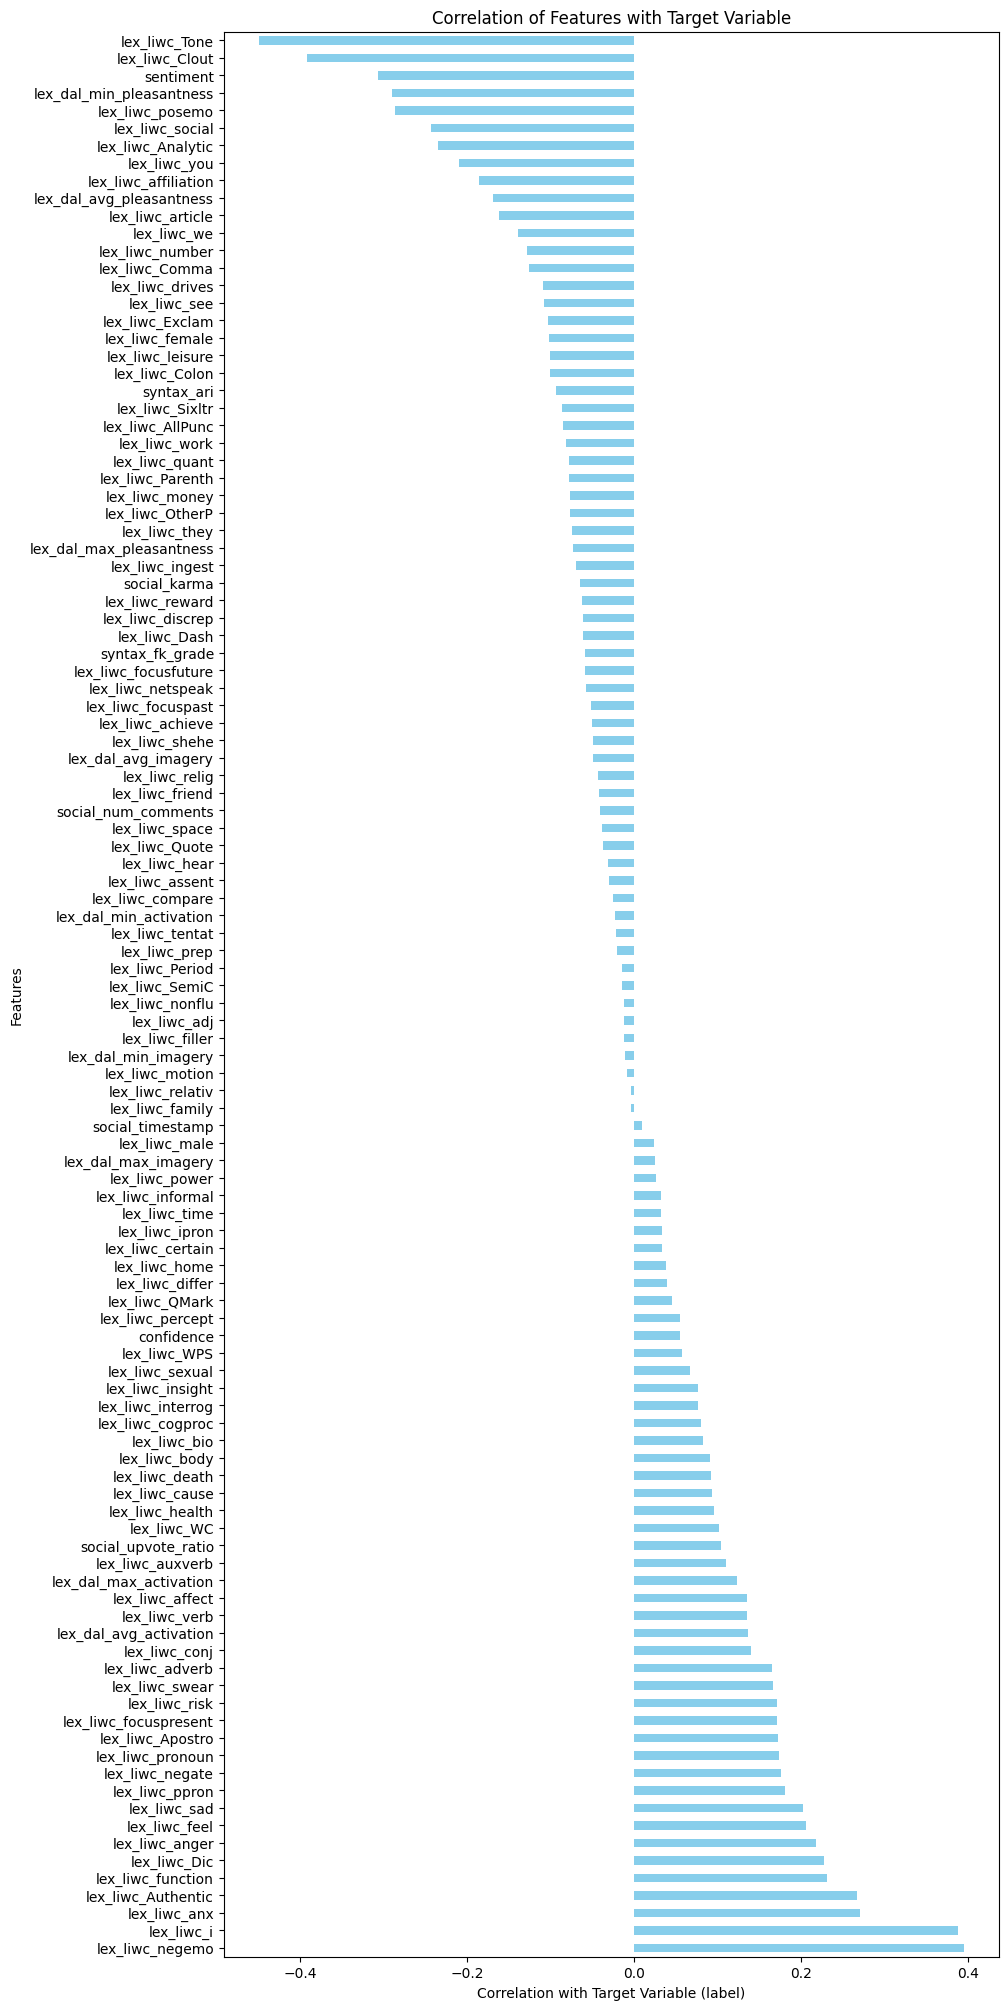

The most important features, further analyzed are:
lex_liwc_Tone: -0.4494272253421694
lex_liwc_negemo: 0.39418748153570915
lex_liwc_Clout: -0.39151992153944015
lex_liwc_i: 0.38722105263434053
sentiment: -0.30695592170730995


In [3]:
# Join datasets
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)
x_train_temp = X_train.reset_index()
x_test_temp = X_test.reset_index()
X_combined = pd.concat([x_train_temp, x_test_temp], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train_series, y_test_series], axis=0).reset_index(drop=True)
combined_data = pd.concat([X_combined, y_combined], axis=1)

# Calculate correlation
numeric_columns = combined_data.select_dtypes(include=['number']).columns
correlation = combined_data[numeric_columns].corr()['label']
correlation = correlation.drop(['label', 0, 'id'], axis=0)
correlation = correlation.sort_values(ascending=False)

plt.figure(figsize=(10, 25))
correlation.plot(kind='barh', color='skyblue')
plt.xlabel('Correlation with Target Variable (label)')
plt.ylabel('Features')
plt.title('Correlation of Features with Target Variable')
plt.show()

top_features = correlation.abs().nlargest(5)
print('The most important features, further analyzed are:')
for feature, correlation_value in top_features.items():
    print(f'{feature}: {correlation[feature]}')

In [4]:
def train_and_eval(clf, X_train, y_train, X_test, y_test):
    numeric_features = X_train.drop(columns=['text', 'subreddit']).columns

    numeric_transformer = StandardScaler()
    X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_features])
    X_test_numeric = numeric_transformer.transform(X_test[numeric_features])

    count_vect_text = CountVectorizer()
    X_train_text = count_vect_text.fit_transform(X_train['text'])
    X_test_text = count_vect_text.transform(X_test['text'])

    count_vect_text = CountVectorizer()
    X_train_subreddit = count_vect_text.fit_transform(X_train['subreddit'])
    X_test_subreddit = count_vect_text.transform(X_test['subreddit'])

    X_train_processed = np.hstack((X_train_numeric, X_train_text.toarray()))
    X_train_processed = np.hstack((X_train_processed, X_train_subreddit.toarray()))
    X_test_processed = np.hstack((X_test_numeric, X_test_text.toarray()))
    X_test_processed = np.hstack((X_test_processed, X_test_subreddit.toarray()))

    clf.fit(X_train_processed, y_train)
    y_pred = clf.predict(X_test_processed)

    return metrics.classification_report(y_test, y_pred, target_names=['no stress', 'stress']), y_test, y_pred

def analyze_results(y_test, y_pred):
    df_test = get_full_test_data()

    feature_names = top_features.index

    false_negatives_feature_scores = []
    false_positives_feature_scores = []
    true_negatives_feature_scores = []
    true_positives_feature_scores = []

    false_negatives = [i for i, (actual, pred) in enumerate(zip(y_test, y_pred)) if actual == 1 and pred == 0]
    false_positives = [i for i, (actual, pred) in enumerate(zip(y_test, y_pred)) if actual == 0 and pred == 1]
    true_negatives = [i for i, (actual, pred) in enumerate(zip(y_test, y_pred)) if actual == 0 and pred == 0]
    true_positives = [i for i, (actual, pred) in enumerate(zip(y_test, y_pred)) if actual == 1 and pred == 1]

    if (len(false_negatives) != 0):
        print("\nFalse Negatives:")
    for count, index in enumerate(false_negatives):
        feature_values = [df_test.loc[index, feature] for feature in feature_names]
        false_negatives_feature_scores.append(feature_values)
        if count <= 5:
            print(f'Actual: Stress, Predicted: No Stress, Features: {feature_values}, Text: {df_test.loc[index, "text"]}')

    if (len(false_positives) != 0):
        print("\nFalse Positives:")
    for count, index in enumerate(false_positives):
        feature_values = [df_test.loc[index, feature] for feature in feature_names]
        false_positives_feature_scores.append(feature_values)
        if count <= 5:
            print(f'Actual: No Stress, Predicted: Stress, Features: {feature_values}, Text: {df_test.loc[index, "text"]}')

    for count, index in enumerate(true_negatives):
        feature_values = [df_test.loc[index, feature] for feature in feature_names]
        true_negatives_feature_scores.append(feature_values)

    for count, index in enumerate(true_positives):
        feature_values = [df_test.loc[index, feature] for feature in feature_names]
        true_positives_feature_scores.append(feature_values)

    plot_distributions(
        false_negatives_feature_scores,
        false_positives_feature_scores,
        true_negatives_feature_scores,
        true_positives_feature_scores,
        feature_names
    )

def plot_distributions(false_negatives, false_positives, true_negatives, true_positives, feature_names):
    for i, feature_name in enumerate(feature_names):
        data = [
            [example[i] for example in false_negatives],
            [example[i] for example in false_positives],
            [example[i] for example in true_negatives],
            [example[i] for example in true_positives]
        ]
        labels = ['False Negatives', 'False Positives', 'True Negatives', 'True Positives']

        plt.figure(figsize=(10, 6))
        sns.violinplot(data=data, palette=['red', 'purple', 'blue', 'green'], inner="quartile")
        plt.xticks(range(len(labels)), labels)
        plt.title(f'{feature_name} Distribution for Misclassified Examples')
        plt.xlabel('Categories')
        plt.ylabel(f'{feature_name}')
        plt.show()

              precision    recall  f1-score   support

   no stress       1.00      1.00      1.00       346
      stress       1.00      1.00      1.00       369

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



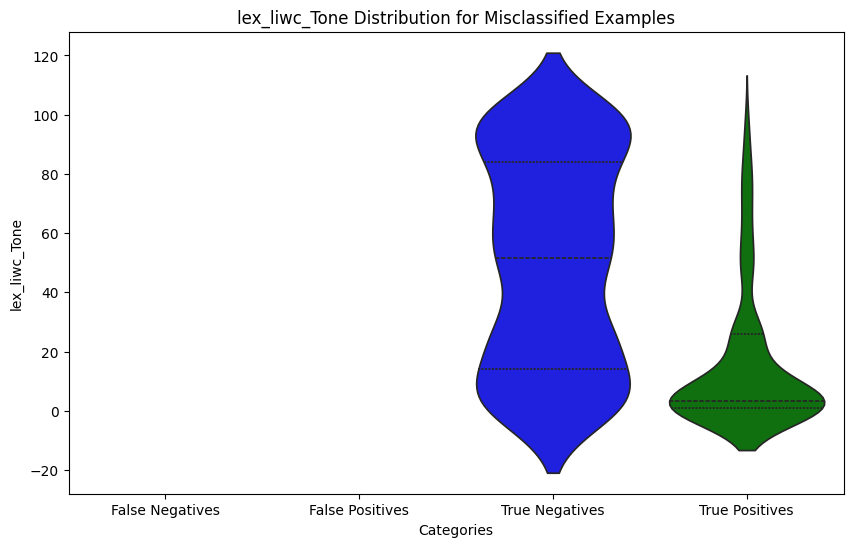

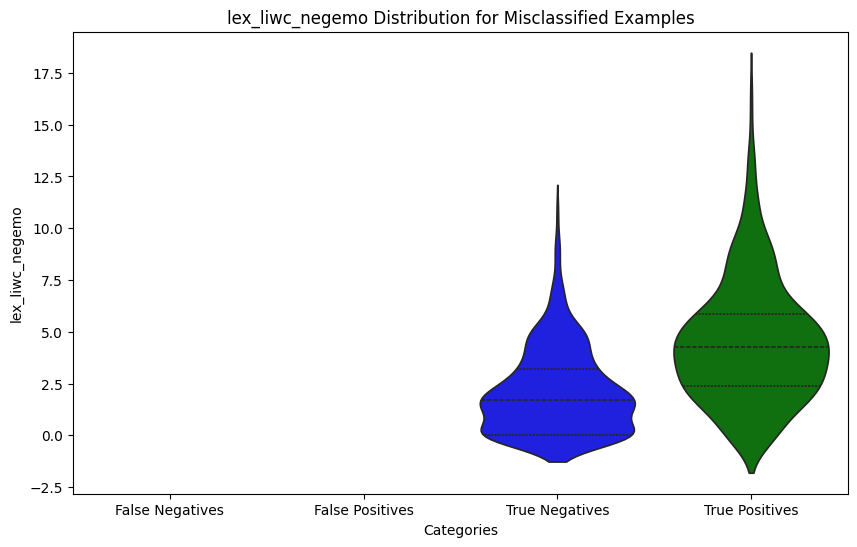

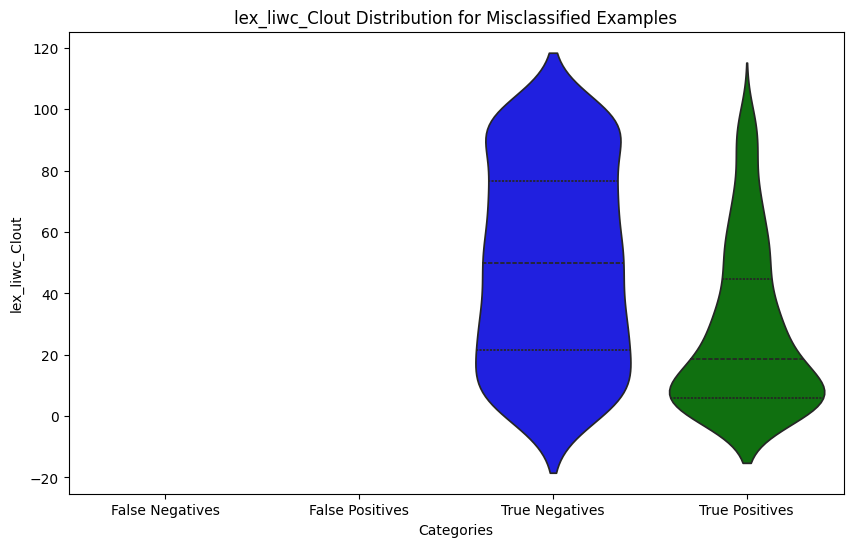

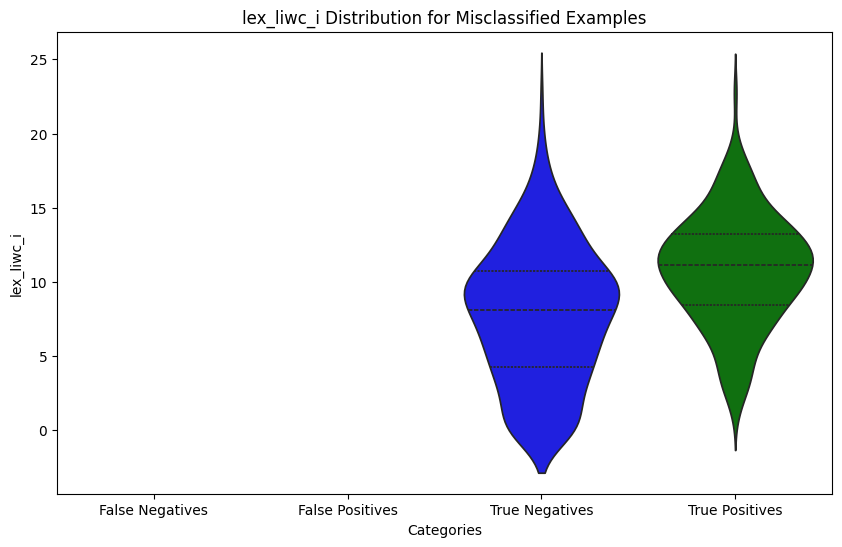

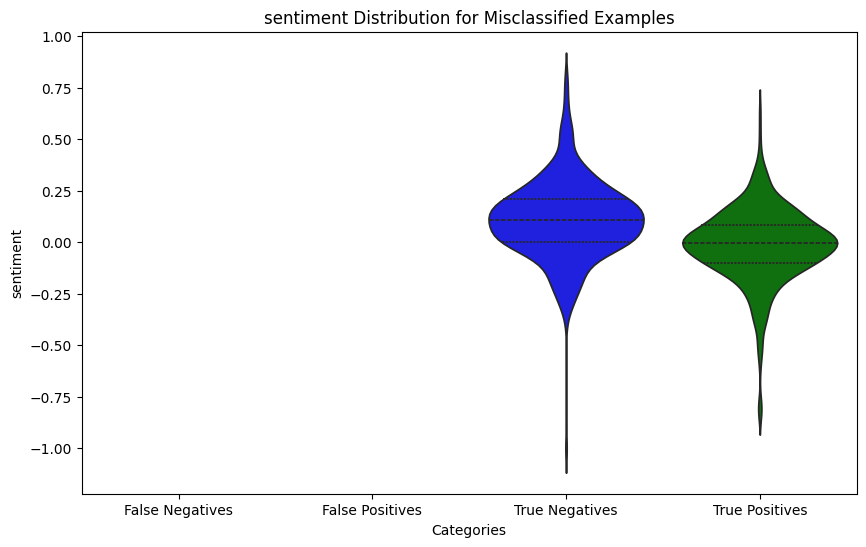

In [5]:
from sklearn.linear_model import LogisticRegression
res = train_and_eval(LogisticRegression(),
                     X_train,
                     y_train,
                     X_test,
                     y_test)
print(res[0])
analyze_results(res[1], res[2])

              precision    recall  f1-score   support

   no stress       0.97      0.98      0.98       346
      stress       0.98      0.98      0.98       369

    accuracy                           0.98       715
   macro avg       0.98      0.98      0.98       715
weighted avg       0.98      0.98      0.98       715


False Negatives:
Actual: Stress, Predicted: No Stress, Features: [1.0, 8.6, 33.35, 6.45, 0.1792307692307692], Text: I’m a previous victim of abuse at home and since moving to university (the abuse ended way before uni) I’ve experienced very frequent nightmares both relating to and completely unrelated to my previous problems. It’s hard for me to go more than 3 nights without having at least a couple of nightmares a night, most of which relating to my trauma. Has anyone else experienced this? If so, would anyone be able to offer some advice on how to address these nightmares as they’re starting to affect my studies. Thank you in advance
Actual: Stress, Predicted: N

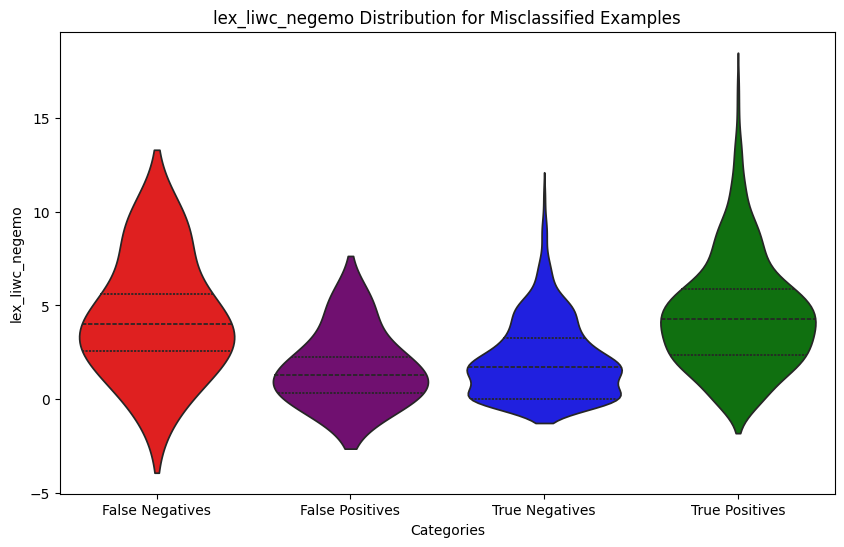

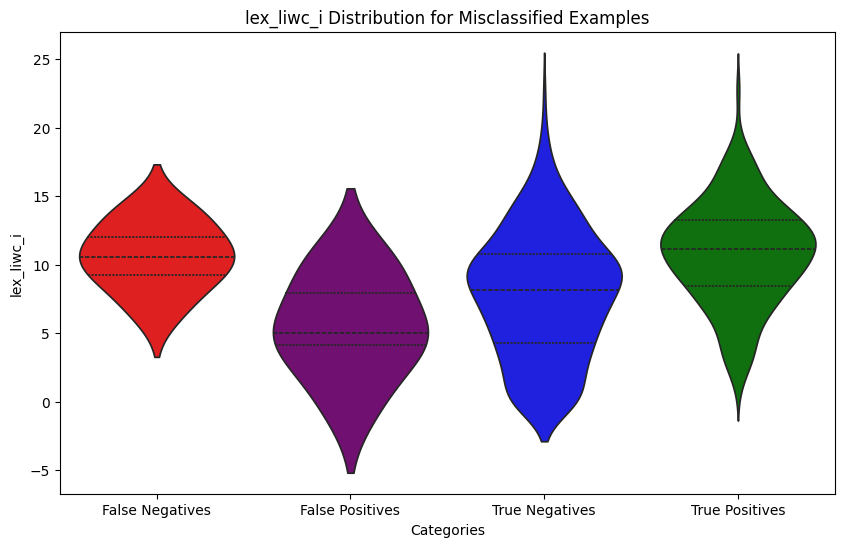

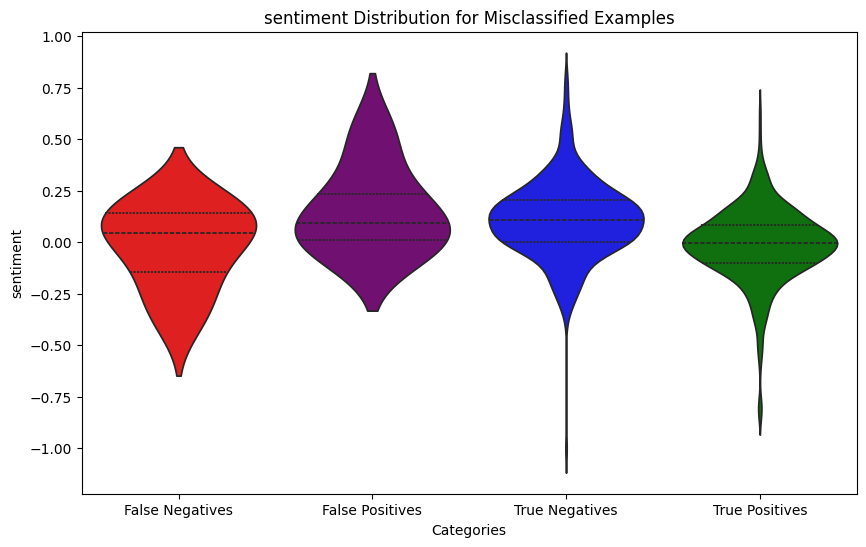

In [6]:
from sklearn.naive_bayes import GaussianNB
res = train_and_eval(GaussianNB(),
                     X_train,
                     y_train,
                     X_test,
                     y_test)
print(res[0])
analyze_results(res[1], res[2])

c:\Users\jonas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\jonas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

   no stress       1.00      1.00      1.00       346
      stress       1.00      1.00      1.00       369

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



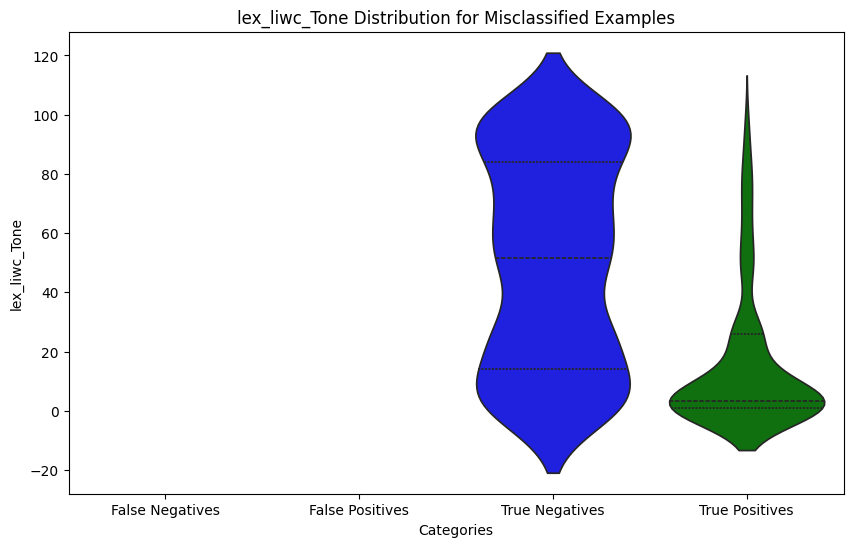

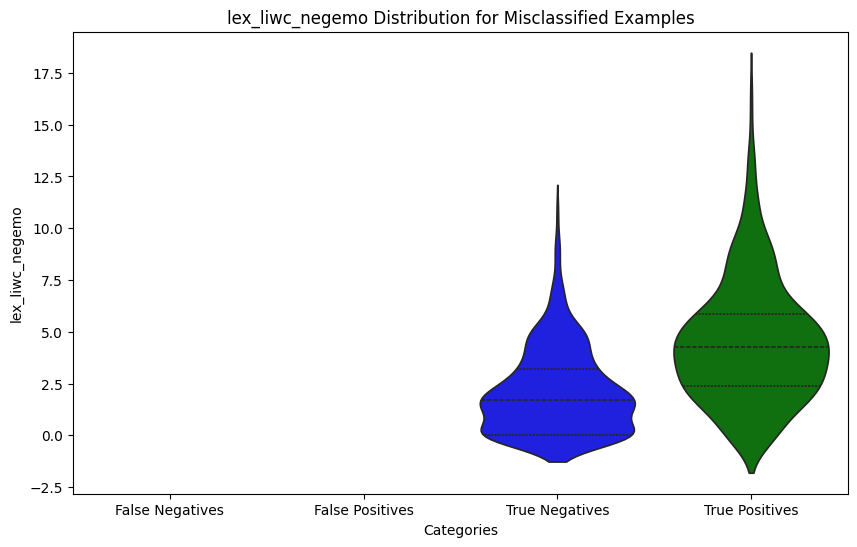

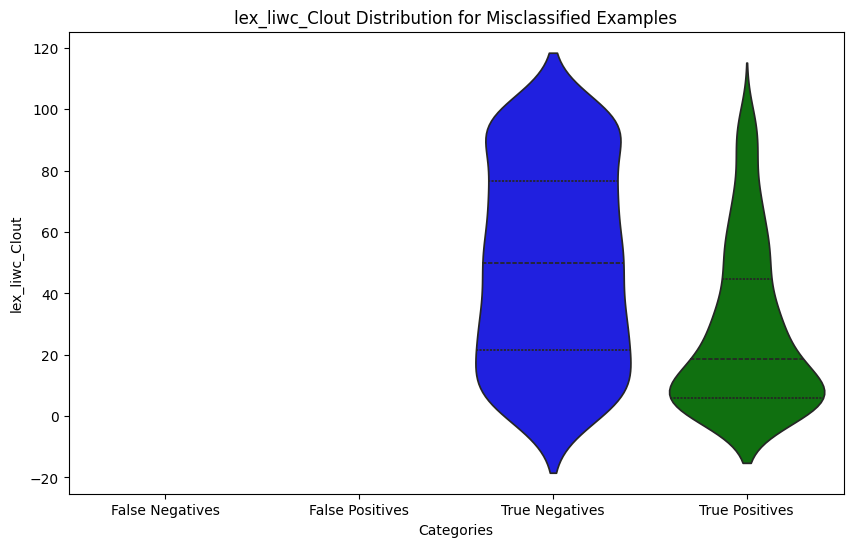

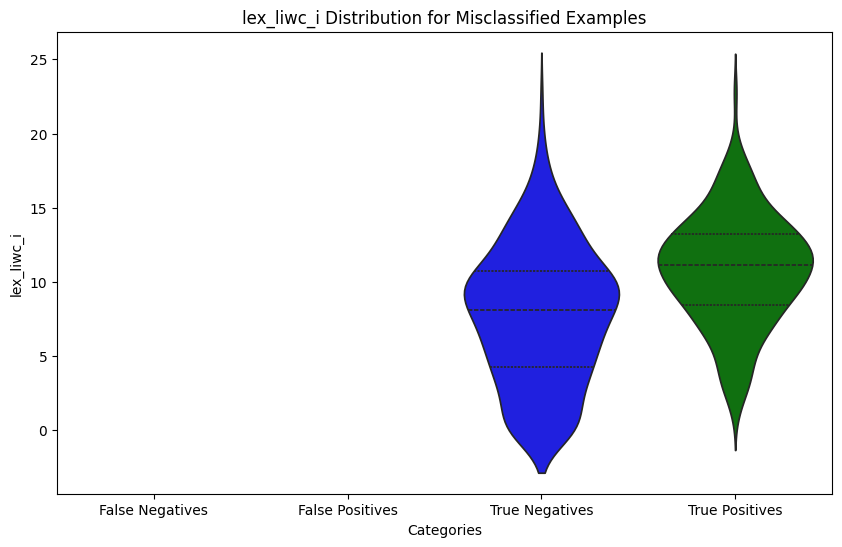

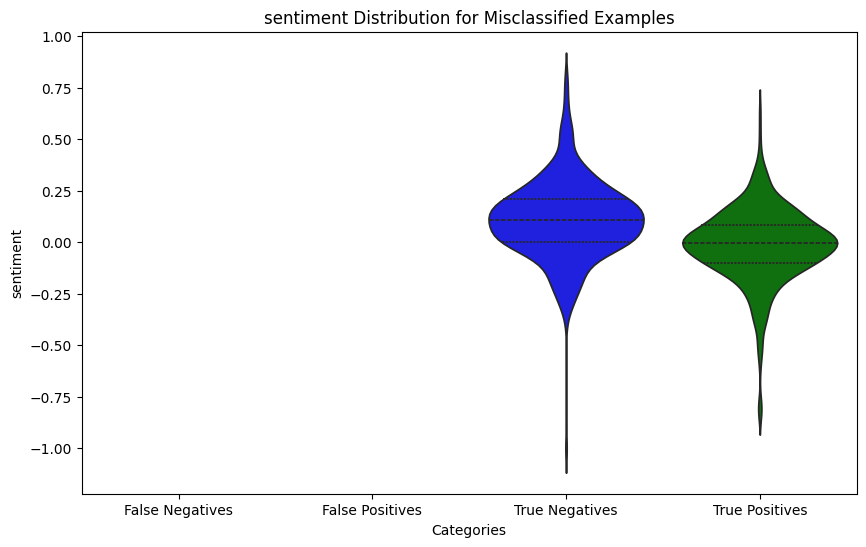

In [7]:
from sklearn.svm import LinearSVC
res = train_and_eval(LinearSVC(),
                     X_train,
                     y_train,
                     X_test,
                     y_test)
print(res[0])
analyze_results(res[1], res[2])

              precision    recall  f1-score   support

   no stress       0.90      0.85      0.87       346
      stress       0.86      0.91      0.89       369

    accuracy                           0.88       715
   macro avg       0.88      0.88      0.88       715
weighted avg       0.88      0.88      0.88       715


False Negatives:
Actual: Stress, Predicted: No Stress, Features: [55.21, 1.56, 73.4, 12.5, 0.4], Text: I've been texting Rebecca on and off for the last week, always about my breakup. Bill went through Rebecca's phone last night and saw she was texting me. He lost his mind. He won't speak to her, and said I betrayed him. I tried to explain that he is my best friend and even if I liked Rebecca I would never try anything, ever.
Actual: Stress, Predicted: No Stress, Features: [11.64, 3.26, 98.04, 4.35, 0.04], Text: Last week while my girlfriend was out of the country I noticed our puppy Luca wasn't acting himself. I took him to the emergency clinic and after some tes

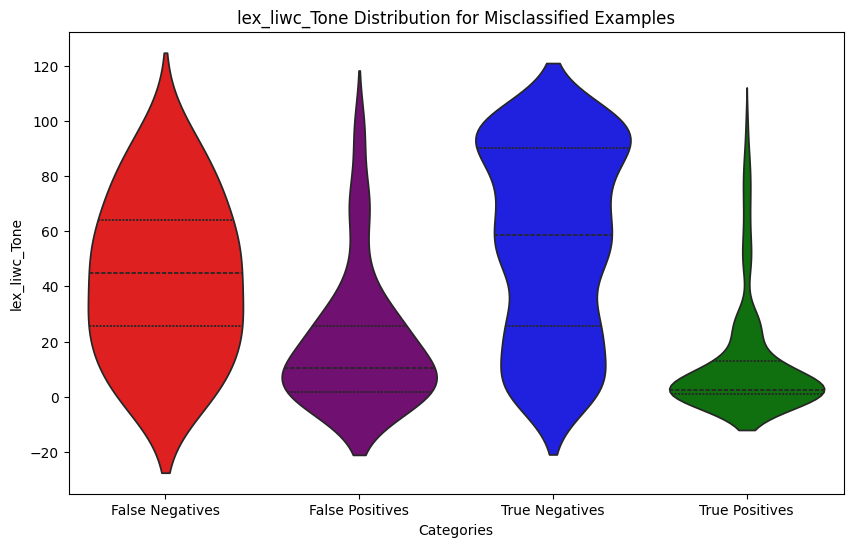

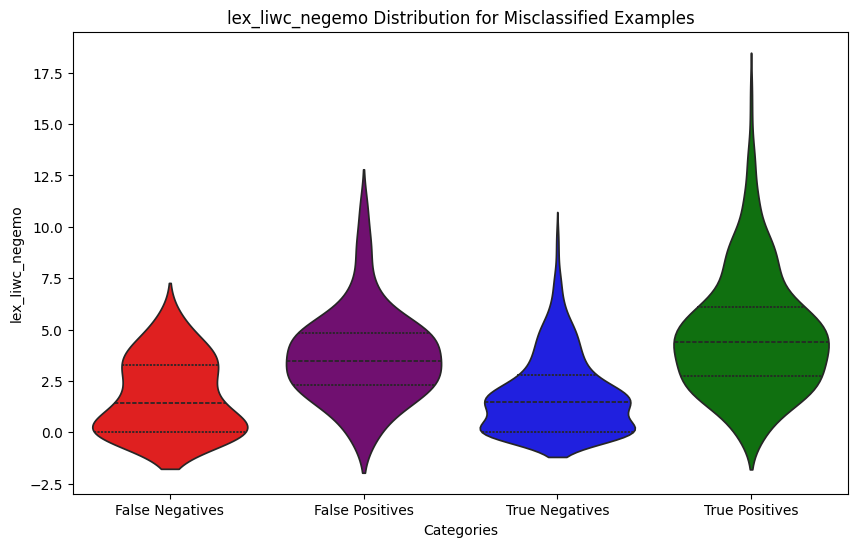

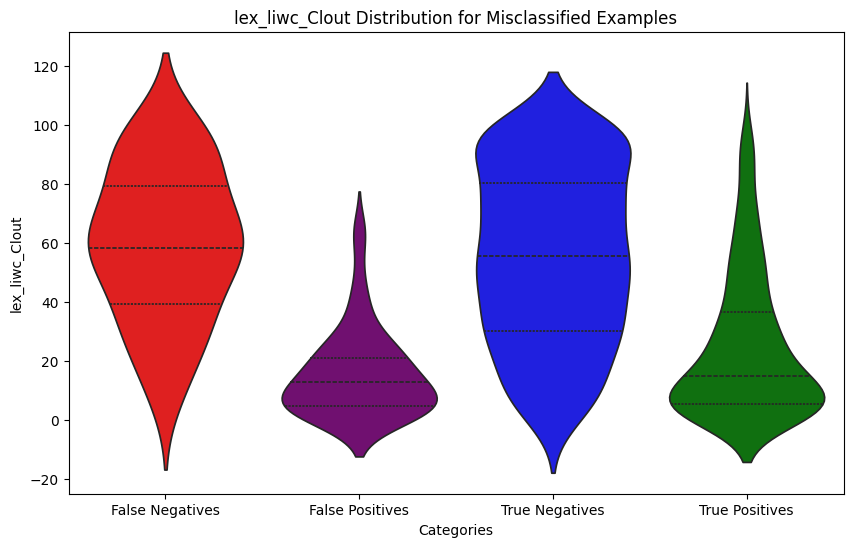

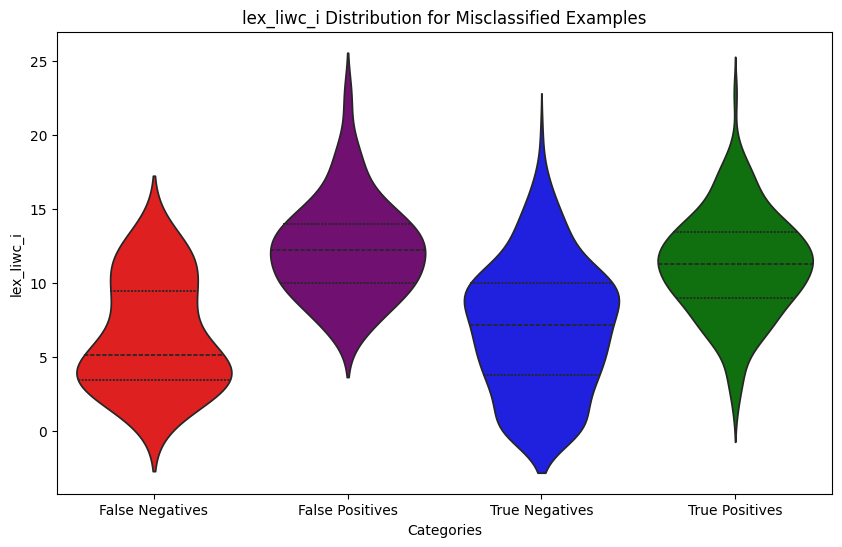

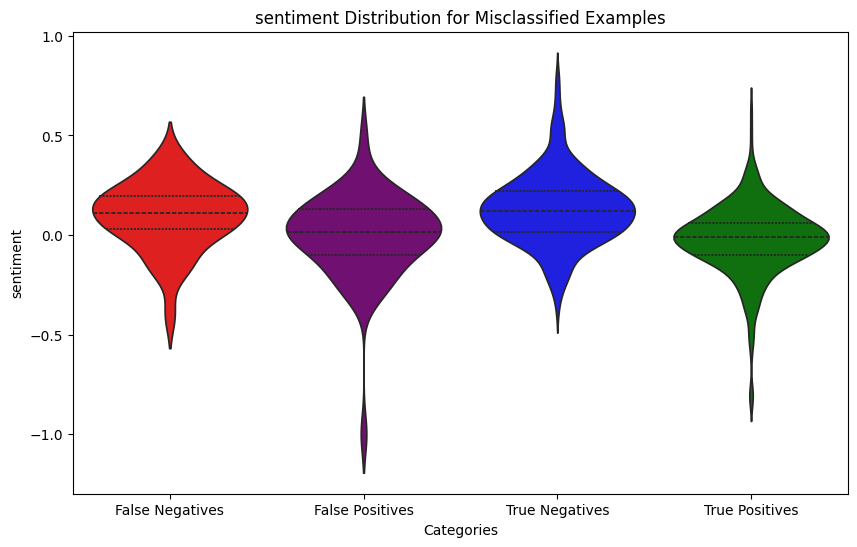

In [8]:
from sklearn.ensemble import RandomForestClassifier
res = train_and_eval(RandomForestClassifier(),
                     X_train,
                     y_train,
                     X_test,
                     y_test)
print(res[0])
analyze_results(res[1], res[2])

              precision    recall  f1-score   support

   no stress       0.79      0.74      0.76       346
      stress       0.77      0.82      0.79       369

    accuracy                           0.78       715
   macro avg       0.78      0.78      0.78       715
weighted avg       0.78      0.78      0.78       715


False Negatives:
Actual: Stress, Predicted: No Stress, Features: [16.15, 2.03, 75.05, 6.08, -0.0368181818181818], Text: We'd be saving so much money with this new housr...its such an expensive city.... I did some googling in their language and found that it was illegal for them to do that. I was excited like oh ok if it happens ill call the police on them....  but now i did some further googling and turns out that if you sign the contract with that in it than everything is on their side... The contract is long term so we'd have to give 6months notice before leaving even if we give it next week ill still have to live six months with this.... i wanna die i swear i h

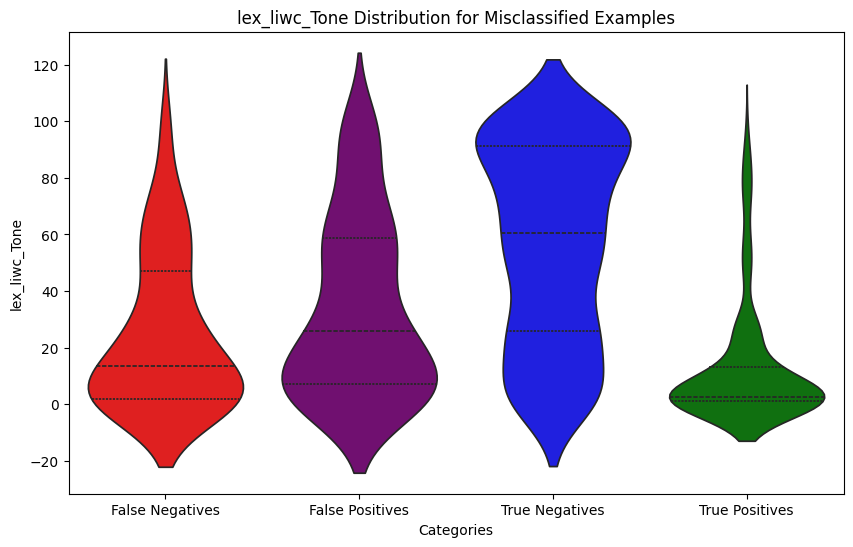

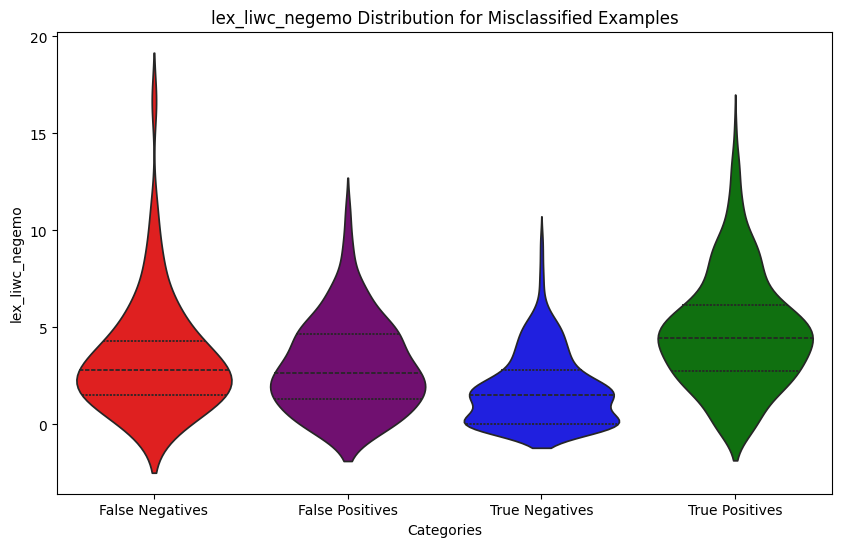

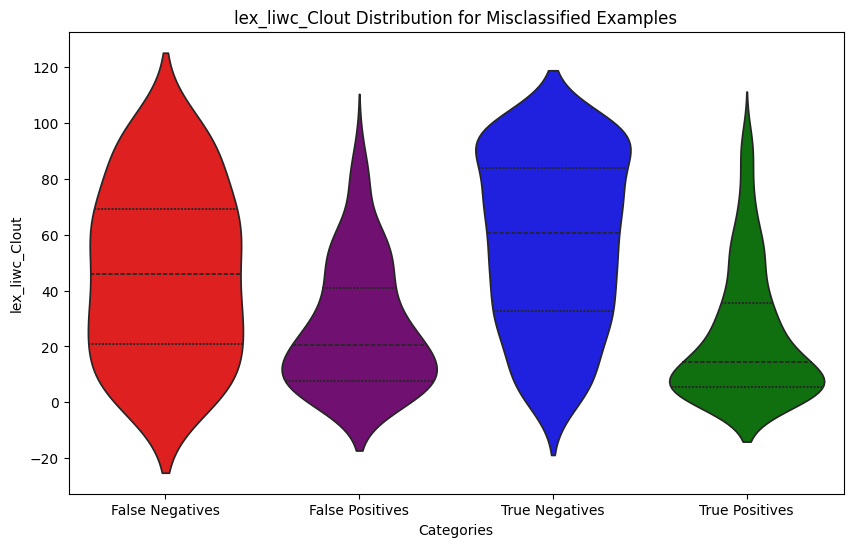

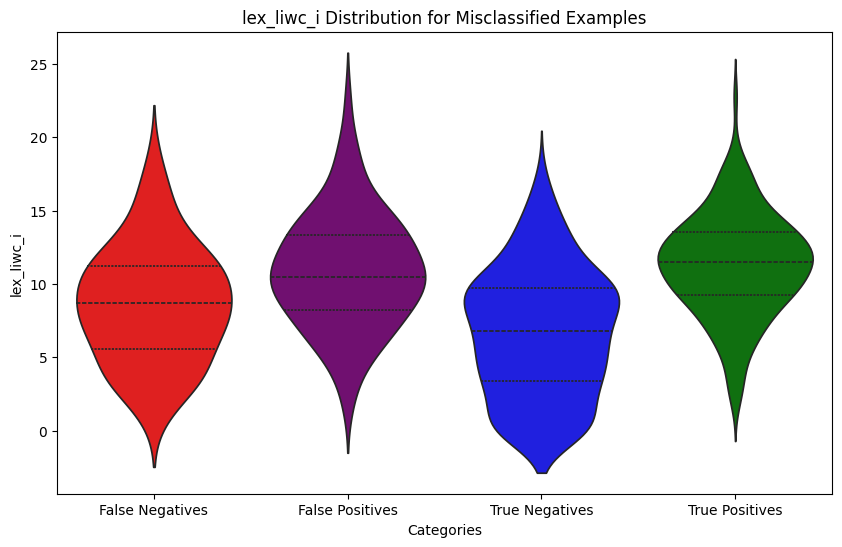

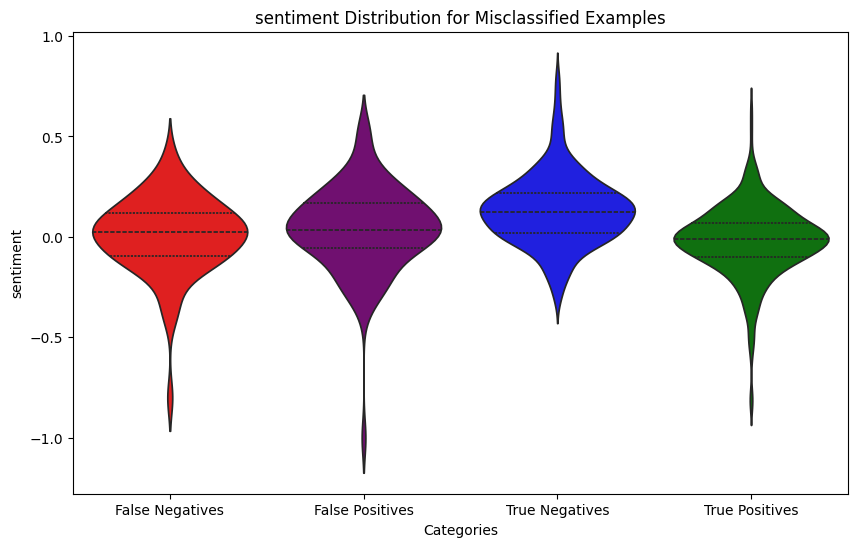

In [9]:
from sklearn.neighbors import KNeighborsClassifier
res = train_and_eval(KNeighborsClassifier(),
                     X_train,
                     y_train,
                     X_test,
                     y_test)
print(res[0])
analyze_results(res[1], res[2])